<a href="https://colab.research.google.com/github/KORALLLL/summer_practice/blob/main/projects/CNN_investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование гиперпараметров свёрточной нейронной сети для решения задачи MNIST.

**Цели исследование**:
- тестирование размера батча
- тестирование разных функций активации
- заменить свёртки с одной 5х5 на два 3х3
- тестирование разных оптимизаторов
- создать разные конфигурации сети и протестировать их.(разное количество свёрточных слоёв с разным количеством каналов с разными пуллингам)

## Эксперимент №1. Тестирование размера батча.

<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>-</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>-</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


датасет: MNIST

размер обучающей выборки:60000

размер тестирующей выборки: 10000

функция потерь: кросс энтропия

оптимизатор: Адам

скорость обучение: 0.001

размер батча: 128,256,512,1024,2048,4096,8192,16384.

количество эпох: 100

In [ ]:
import torch
import torchvision.datasets
import numpy as np
from tqdm import tqdm_notebook as bar

mnist_train = torchvision.datasets.MNIST('./', download = True, train = True)
mnist_test = torchvision.datasets.MNIST('./', download = True, train = False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_data = mnist_train.data.unsqueeze(1).float().to(device)
train_labels = mnist_train.targets.to(device)
test_data = mnist_test.data.unsqueeze(1).float().to(device)
test_labels = mnist_test.targets.to(device)

class LeNet5(torch.nn.Module):
  def __init__(self):
    super(LeNet5,self).__init__()
    self.conv1 = torch.nn.Conv2d(
        in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2
    )
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.conv2 = torch.nn.Conv2d(
        in_channels = 6, out_channels = 16, kernel_size=5, padding = 0
    )
    self.act2 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride = 2)
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.act3 = torch.nn.Tanh()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act4 = torch.nn.Tanh()
    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self,x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)
    return x

batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]

test_accuracy_ar = [[[] for experiment in range(10)] for size in range(len(batch_sizes))]
test_loss_ar = [[[] for experiment in range(10)] for size in range(len(batch_sizes))]

In [ ]:
for batch_size in bar(range(len(batch_sizes)), desc = 'batch_sizes'):
  for experiment in bar(range(10), desc = 'experimneting'):
    lenet = LeNet5().to(device)

    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(lenet.parameters(), lr = 0.001)

    batch = batch_sizes[batch_size]

    for epoch in bar(range(100), desc = 'learning'):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch]

        train_data_batch = train_data[batch_indexes].to(device)
        train_labels_batch = train_labels[batch_indexes].to(device)

        preds = lenet.forward(train_data_batch)

        loss_val = loss(preds, train_labels_batch)
        loss_val.backward()

        optimizer.step()

      test_preds = lenet.forward(test_data)

      test_accuracy = (test_preds.argmax(dim=1) == test_labels).float().mean().data.cpu()

      test_accuracy_ar[batch_size][experiment].append(test_accuracy)

      test_loss_ar[batch_size][experiment].append(loss(test_preds, test_labels).item())

<ipython-input-2-1355efb8c5c3>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_size in bar(range(len(batch_sizes)), desc = 'batch_sizes'):


batch_sizes:   0%|          | 0/8 [00:00<?, ?it/s]

<ipython-input-2-1355efb8c5c3>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in bar(range(10), desc = 'experimneting'):


experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-2-1355efb8c5c3>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(100), desc = 'learning'):


learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

experimneting:   0%|          | 0/10 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

learning:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
time = [98.5, 51.5, 34.5, 30.6, 29.2, 28.5, 28.4, 28.4]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)

Text(0.5, 1.0, 'Зависимость времени от размера батча')

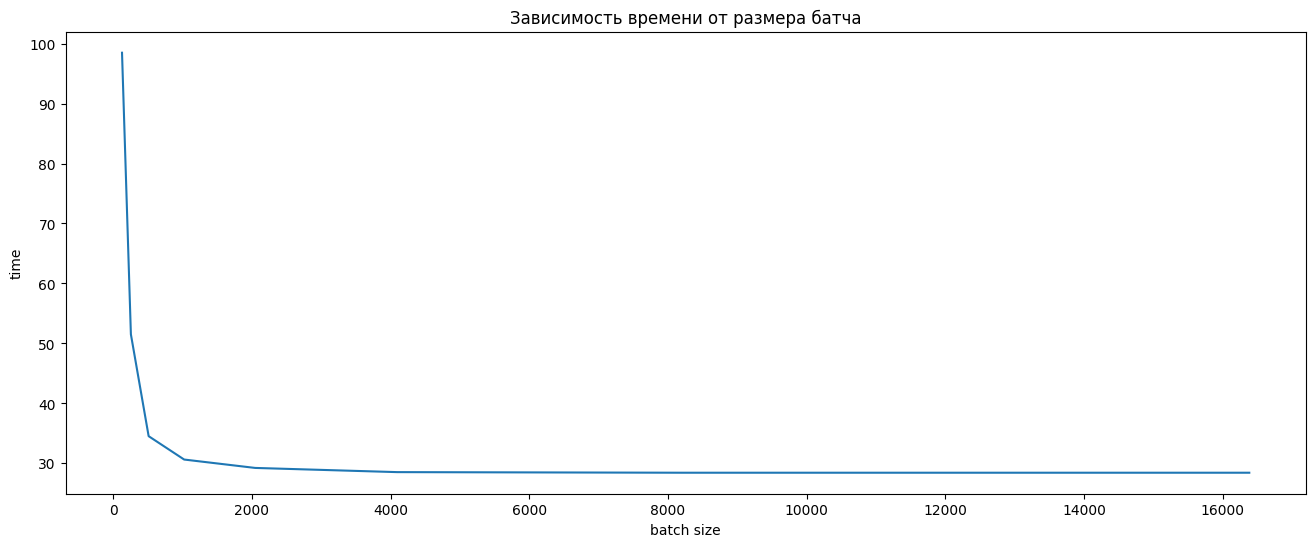

In [ ]:
plt.plot(batch_sizes, time)
plt.xlabel('batch size')
plt.ylabel('time')
plt.title('Зависимость времени от размера батча')

In [ ]:
means_accuracy = [[] for i in range(len(test_accuracy_ar))]
means_loss = [[] for i in range(len(test_loss_ar))]
for batch_size in range(len(test_accuracy_ar)):
  for epoch in range(100):
    avg1 = 0
    avg2 = 0
    for i in range(10):
      avg1 += test_accuracy_ar[batch_size][i][epoch]
      avg2 += test_loss_ar[batch_size][i][epoch]
    means_accuracy[batch_size].append(avg1/10)
    means_loss[batch_size].append(avg2/10)


(0.986, 0.992)

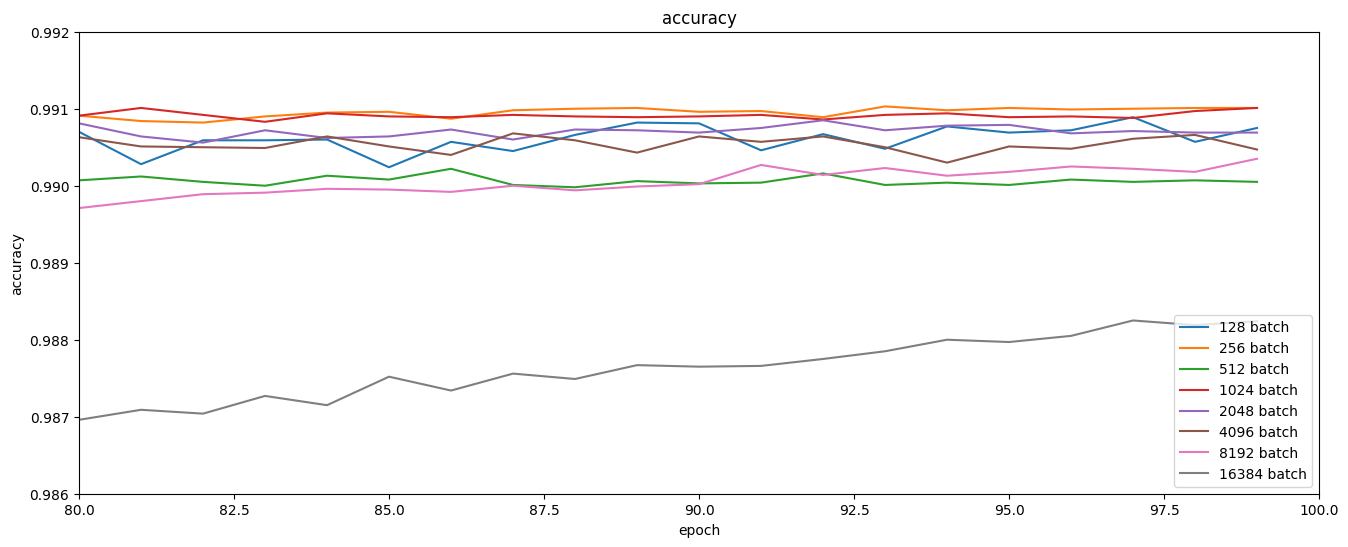

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i in range(8):
  plt.plot(range(100), means_accuracy[i], c=colors[i], label = str(batch_sizes[i])+' batch')
plt.title('accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(80, 100)
plt.ylim(0.986, 0.992)

По средним значениям точности модели лучше всего использовать размер батча 256 или 512.

(0.02, 0.08)

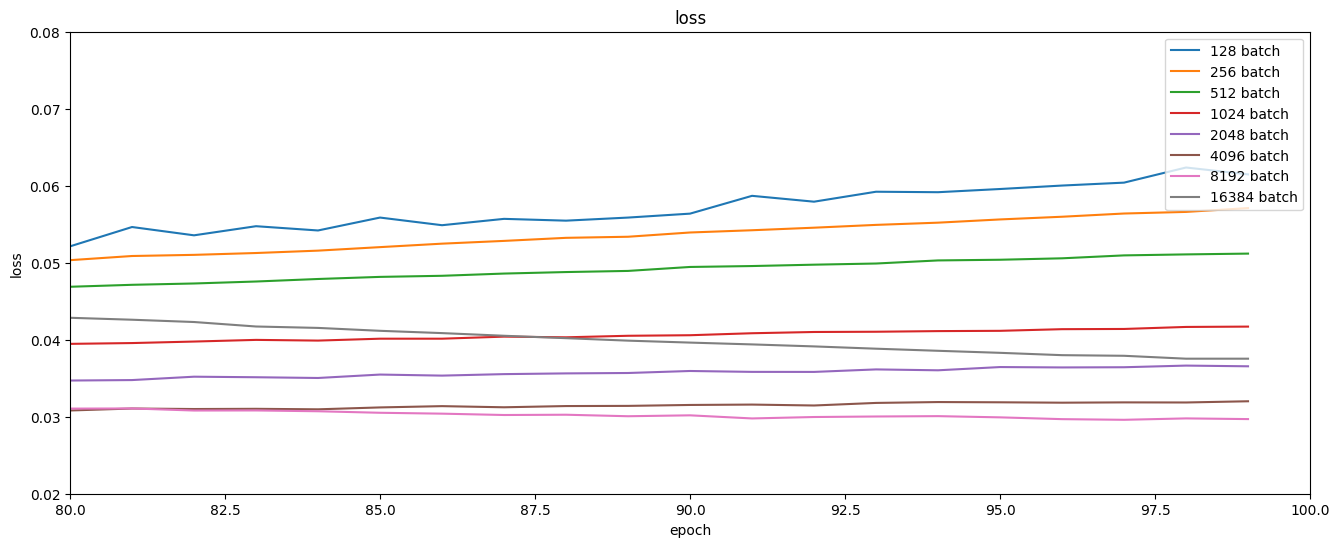

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
for i in range(8):
  plt.plot(range(100), means_loss[i], c=colors[i], label = str(batch_sizes[i])+' batch')
plt.title('loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(80, 100)
plt.ylim(0.02, 0.08)

In [ ]:
x = [[experiment[-1] for experiment in batch] for batch in test_accuracy_ar]

10

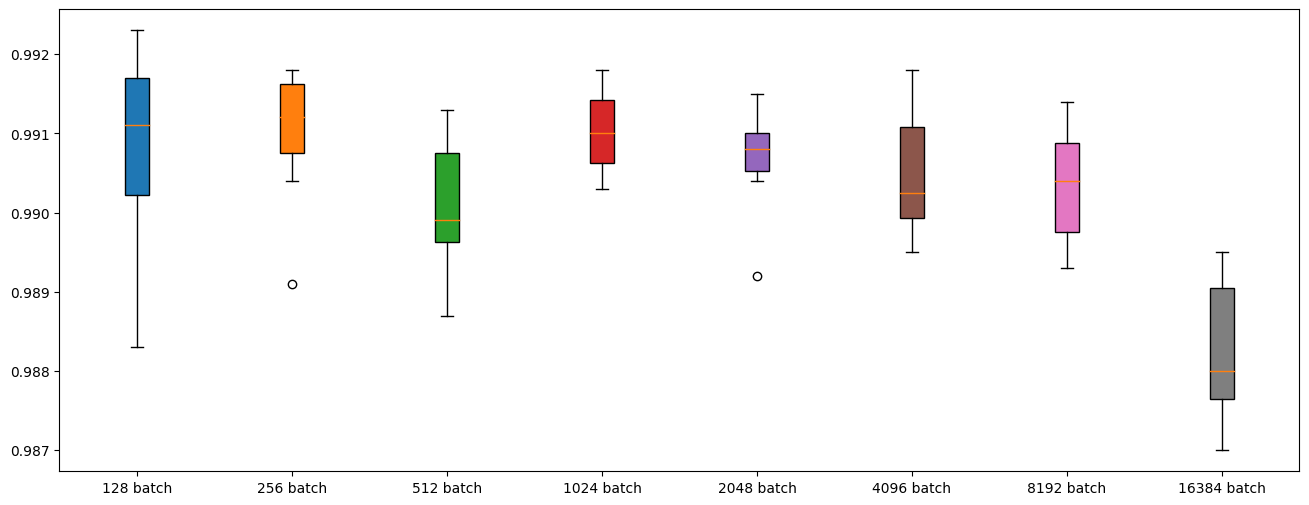

In [ ]:
labels = [str(batch_sizes[i]) + ' batch' for i in range(8)]


for i in range(8):
  y = plt.boxplot(x[i], positions=[i], patch_artist=True)
  y['boxes'][0].set_facecolor(colors[i])
plt.xticks([i for i in range(8)], [str(i) + ' batch' for i in batch_sizes]);


Лучший результат показывают размеры батча 128, 256 и 1024. С учётом того что сеть с размером батча 1024 обучается быстрее, то в качества размера батча будет использовать такое число. Потерями пренебрежом.

Стоит также отметить, что сеть с размером батча показала результат выше 0.992. НО это всё-таки выброс, а не закономерность.

## Эксперимент №2. Тестирование различных функций активации.

датасет: MNIST

размер обучающей выборки:60000

размер тестирующей выборки: 10000

функция потерь: кросс энтропия

оптимизатор: Адам

скорость обучение: 0.001

размер батча: 1000

количество эпох: 100


Первая модель

<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>-</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>-</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


Вторая модель
<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>tanh</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


Третья модель
<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


Четвёртая модель
<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>ELU</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>ELU</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>ELU</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>ELU</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>ELU</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>ELU</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


Пятая модель
<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>LeacyReLu</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>LeacyReLu</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>LeacyReLu</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>LeacyReLu</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>LeacyReLu</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>LeacyReLu</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


Пятая модель
<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>SeLu</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>SeLu</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>SeLu</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>SeLu</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>SeLu</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>SeLu</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


In [ ]:
import torch
import torchvision.datasets
import numpy as np
from tqdm import tqdm_notebook as bar

mnist_train = torchvision.datasets.MNIST('./', download = True, train = True)
mnist_test = torchvision.datasets.MNIST('./', download = True, train = False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_data = mnist_train.data.unsqueeze(1).float().to(device)
train_labels = mnist_train.targets.to(device)
test_data = mnist_test.data.unsqueeze(1).float().to(device)
test_labels = mnist_test.targets.to(device)

class LeNetWithoutMod(torch.nn.Module):
  def __init__(self):
    super(LeNetWithoutMod, self).__init__()
    self.conv1 = torch.nn.Conv2d(
        in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2
    )
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.conv2 = torch.nn.Conv2d(
        in_channels = 6, out_channels = 16, kernel_size = 5, padding = 0
    )
    self.act2 = torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.act3 = torch.nn.Tanh()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act4 = torch.nn.Tanh()
    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x = self.fc3(x)
    return x

class LeNetWithMod(torch.nn.Module):
  def __init__(self, activation_function):
    super(LeNetWithMod, self).__init__()
    self.conv1 = torch.nn.Conv2d(
        in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2
    )
    self.act1 = activation_function()
    self.pool1 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.act2 = activation_function()
    self.conv2 = torch.nn.Conv2d(
        in_channels = 6, out_channels = 16, kernel_size = 5, padding = 0
    )
    self.act3 = activation_function()
    self.pool2 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.act4 = activation_function()
    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.act5 = activation_function()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act6 = activation_function()
    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    x = self.act2(x)
    x = self.conv2(x)
    x = self.act3(x)
    x = self.pool2(x)
    x = self.act4(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act5(x)
    x = self.fc2(x)
    x = self.act6(x)
    x = self.fc3(x)
    return x

activation_functions = [torch.nn.Tanh, torch.nn.ReLU, torch.nn.ELU, torch.nn.LeakyReLU, torch.nn.SELU]

train_accuracy_history = [[[] for epoch in range(100)] for model in range(6)]
test_accuracy_history = [[[] for epoch in range(100)] for model in range(6)]

In [ ]:
for model in bar(range(6), desc = 'model'):
  for experiment in bar(range(10), desc = 'experimenting on model'):
    if model == 0:
      lenet = LeNetWithoutMod().to(device)
    else:
      lenet = LeNetWithMod(activation_functions[model - 1]).to(device)

    batch_size = 1000

    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

    for epoch in bar(range(100), desc = 'learning model'):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]

        train_data_batch = train_data[batch_indexes].to(device)
        train_labels_batch = train_labels[batch_indexes].to(device)

        preds = lenet.forward(train_data_batch)

        loss_val = loss(preds, train_labels_batch)
        loss_val.backward()

        optimizer.step()

      train_preds = lenet.forward(train_data)
      test_preds = lenet.forward(test_data)

      train_accuracy = (train_preds.argmax(dim = 1) == train_labels).float().mean().data.cpu()
      test_accuracy = (test_preds.argmax(dim = 1) == test_labels).float().mean().data.cpu()

      train_accuracy_history[model][epoch].append(train_accuracy)
      test_accuracy_history[model][epoch].append(test_accuracy)

<ipython-input-4-5d49f1ab9c27>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model in bar(range(6), desc = 'model'):


model:   0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-4-5d49f1ab9c27>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in bar(range(10), desc = 'experimenting on model'):


experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-4-5d49f1ab9c27>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(100), desc = 'learning model'):


learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

learning model:   0%|          | 0/100 [00:00<?, ?it/s]

(0.99, 0.9925)

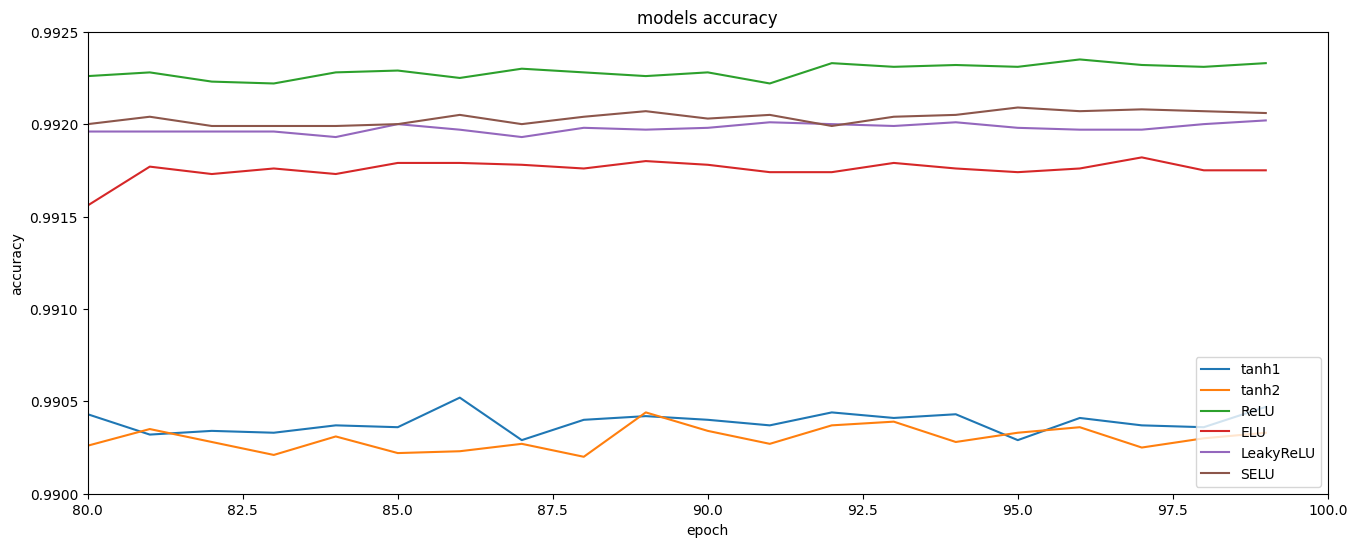

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

test_means = [[sum(i)/10 for i in model] for model in test_accuracy_history]

titles = ['tanh1', 'tanh2', 'ReLU', 'ELU', 'LeakyReLU', 'SELU']

for model in range(6):
  plt.plot(range(100), test_means[model], c = colors[model], label = titles[model])
plt.title('models accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(80,100)
plt.ylim(0.99, 0.9925)

По графику средних величин можно сделать вывод, что лучшая функция для данной модели - ReLU.

Text(0.5, 1.0, 'models accuracy')

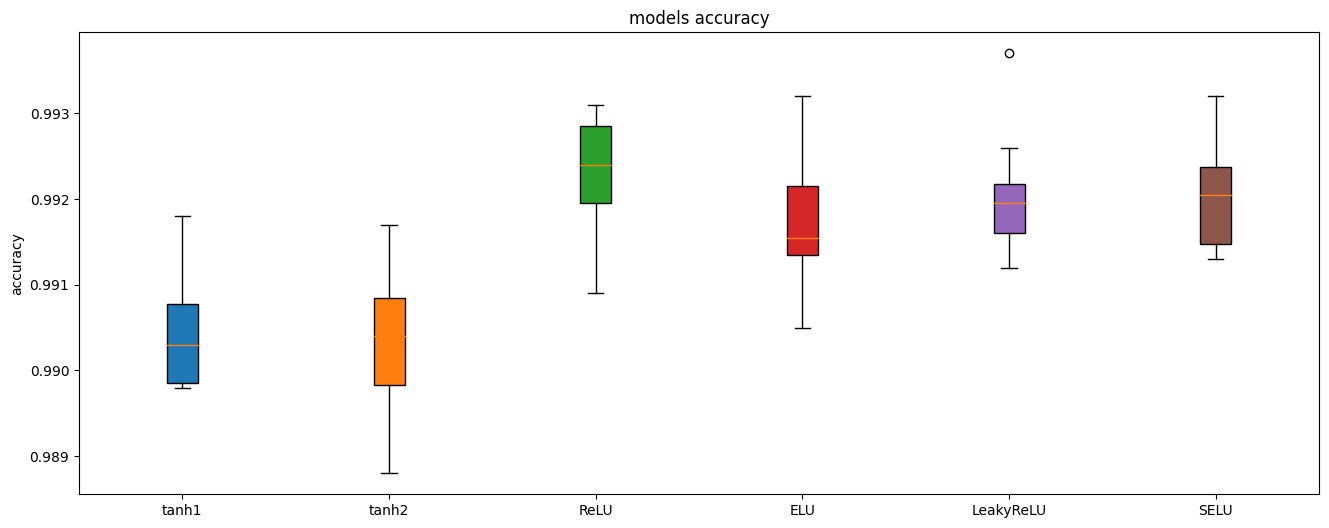

In [ ]:
for model in range(6):
  y = plt.boxplot(test_accuracy_history[model][-1], positions=[model], patch_artist=True)
  y['boxes'][0].set_facecolor(colors[model])

plt.xticks([i for i in range(6)], titles)
plt.ylabel('accuracy')
plt.title('models accuracy')

**Вывод**: Лучше всего себя показали модели с функциями активации ReLU, LeakyReLU, SELU. В качестве функции активации будем использовать ReLU.

## Эксперимент №3. Изменение свёрточных слоёв.

<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>3*3</th>
    <th>1</th>
    <th>-</th>
  </tr>
  <tr>
    <th>2</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>3*3</th>
    <th>1</th>
    <th>ReLU</th>
  </tr>
  <tr>
    <th>3</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>ReLU</th>
  </tr>
  <tr>
    <th>4</th>
    <th>convoluation</th>
    <th>16</th>
    <th>12*12</th>
    <th>3*3</th>
    <th>1</th>
    <th>-</th>
  </tr>
  <tr>
    <th>5</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>3*3</th>
    <th>1</th>
    <th>ReLU</th>
  </tr>
  <tr>
    <th>6</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>ReLU</th>
  </tr>
  <tr>
    <th>7</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>ReLU</th>
  </tr>
  <tr>
    <th>8</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>ReLU</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


<table>
  <tr>
    <th>layer</th>
    <th>layer type2</th>
    <th>feature maps</th>
    <th>size</th>
    <th>kernel size</th>
    <th>stride</th>
    <th>activation</th>
  </tr>
  <tr>
    <th>input</th>
    <th>image</th>
    <th>1</th>
    <th>28*28</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
  <tr>
    <th>1</th>
    <th>convoluation</th>
    <th>6</th>
    <th>28*28</th>
    <th>5*5</th>
    <th>1</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>2</th>
    <th>average pooling</th>
    <th>6</th>
    <th>14*14</th>
    <th>2*2</th>
    <th>2</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>3</th>
    <th>convoluation</th>
    <th>16</th>
    <th>10*10</th>
    <th>5*5</th>
    <th>1</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>4</th>
    <th>average pooling</th>
    <th>16</th>
    <th>5*5</th>
    <th>2*2</th>
    <th>2</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>5</th>
    <th>fully connected</th>
    <th>-</th>
    <th>120</th>
    <th>-</th>
    <th>-</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>6</th>
    <th>fully connected</th>
    <th>-</th>
    <th>84</th>
    <th>-</th>
    <th>-</th>
    <th>ReLu</th>
  </tr>
  <tr>
    <th>output</th>
    <th>fully connected</th>
    <th>-</th>
    <th>10</th>
    <th>-</th>
    <th>-</th>
    <th>-</th>
  </tr>
</table>


датасет: MNIST

размер обучающей выборки:60000

размер тестирующей выборки: 10000

функция потерь: кросс энтропия

оптимизатор: Адам

скорость обучение: 0.001

размер батча: 1000

количество эпох: 100


In [1]:
import torch
import torchvision.datasets
from tqdm import tqdm_notebook as bar
import numpy as np
import time as tm
import gc

mnist_train = torchvision.datasets.MNIST('./', download = True, train = True)
mnist_test = torchvision.datasets.MNIST('./', download = True, train = False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_data = mnist_train.data.float().unsqueeze(1).to(device)
train_labels = mnist_train.targets.to(device)
test_data = mnist_test.data.float().unsqueeze(1).to(device)
test_labels = mnist_test.targets.to(device)

class LeNet2Conv(torch.nn.Module):
  def __init__(self):
    super(LeNet2Conv, self).__init__()
    self.conv1 = torch.nn.Conv2d(
        in_channels = 1, out_channels = 6, kernel_size = 5, padding = 2
    )
    self.act1 = torch.nn.ReLU()
    self.pool1 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.act2 = torch.nn.ReLU()
    self.conv2 = torch.nn.Conv2d(
        in_channels = 6, out_channels = 16, kernel_size = 5, padding = 0
    )
    self.act3 = torch.nn.ReLU()
    self.pool2 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.act4 = torch.nn.ReLU()
    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.act5 = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act6 = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(84, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    x = self.act2(x)
    x = self.conv2(x)
    x = self.act3(x)
    x = self.pool2(x)
    x = self.act4(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act5(x)
    x = self.fc2(x)
    x = self.act6(x)
    x = self.fc3(x)
    return x

class LeNet4Conv(torch.nn.Module):
  def __init__(self):
    super(LeNet4Conv, self).__init__()
    self.conv1 = torch.nn.Conv2d(
        in_channels = 1, out_channels = 3, kernel_size = 3, padding = 1
    )
    self.conv2 = torch.nn.Conv2d(
        in_channels = 3, out_channels = 6, kernel_size = 3, padding = 1
    )
    self.act1 = torch.nn.ReLU()
    self.pool1 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.act2 = torch.nn.ReLU()
    self.conv3 = torch.nn.Conv2d(
        in_channels = 6, out_channels = 11, kernel_size = 3, padding = 0
    )
    self.conv4 = torch.nn.Conv2d(
        in_channels = 11, out_channels = 16, kernel_size = 3, padding = 0
    )
    self.act3 = torch.nn.ReLU()
    self.pool2 = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.act4 = torch.nn.ReLU()
    self.fc1 = torch.nn.Linear(16*5*5, 120)
    self.act5 = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(120, 84)
    self.act6 = torch.nn.ReLU()
    self.fc3 = torch.nn.Linear(84,10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.act1(x)
    x = self.pool1(x)
    x = self.act2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.act3(x)
    x = self.pool2(x)
    x = self.act4(x)
    x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
    x = self.fc1(x)
    x = self.act5(x)
    x = self.fc2(x)
    x = self.act6(x)
    x = self.fc3(x)
    return x

train_accuracy_history = [[[] for epoch in range(100)] for model in range(2)]
test_accuracy_history = [[[] for epoch in range(100)] for model in range(2)]

times = [[] for model in range(2)]
memories = [[] for model in range(2)]

In [2]:
for model in bar(range(2), desc= 'testing models'):
  for experiment in bar(range(10), desc = 'experimenting on model'):
    time1 = tm.time()

    if model == 0:
      lenet = LeNet2Conv().to(device)
    else:
      lenet = LeNet4Conv().to(device)

    batch_size = 1000

    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

    if device == 'cuda:0':
      torch.cuda.empty_cash()

    gc.collect()

    mem1 = torch.cuda.memory_allocated()

    for epoch in bar(range(100), desc = 'lerning model'):
      order = np.random.permutation(len(train_data))

      for start_index in range(0, len(train_data), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index + batch_size]

        train_data_batch = train_data[batch_indexes].to(device)
        train_labels_batch = train_labels[batch_indexes].to(device)

        preds = lenet.forward(train_data_batch)

        loss_val = loss(preds, train_labels_batch)
        loss_val.backward()

        optimizer.step()

      train_preds = lenet.forward(train_data)
      test_preds = lenet.forward(test_data)

      train_accuracy_history[model][epoch].append((train_preds.argmax(dim = 1) == train_labels).float().mean().data.cpu())
      test_accuracy_history[model][epoch].append((test_preds.argmax(dim = 1) == test_labels).float().mean().data.cpu())


    mem2 = torch.cuda.memory_allocated()
    if mem2>mem1:
      memories[model].append((mem2 - mem1) / 1024/1024)
    time2 = tm.time()
    times[model].append(time2-time1)

<ipython-input-2-b6677babe885>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model in bar(range(2), desc= 'testing models'):


testing models:   0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-2-b6677babe885>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for experiment in bar(range(10), desc = 'experimenting on model'):


experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-2-b6677babe885>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in bar(range(100), desc = 'lerning model'):


lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

experimenting on model:   0%|          | 0/10 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

lerning model:   0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 6.0)

train_means = [[sum(i)/10 for i in model] for model in train_accuracy_history]
test_means = [[sum(i)/10 for i in model] for model in test_accuracy_history]

Text(0, 0.5, 'accuracy')

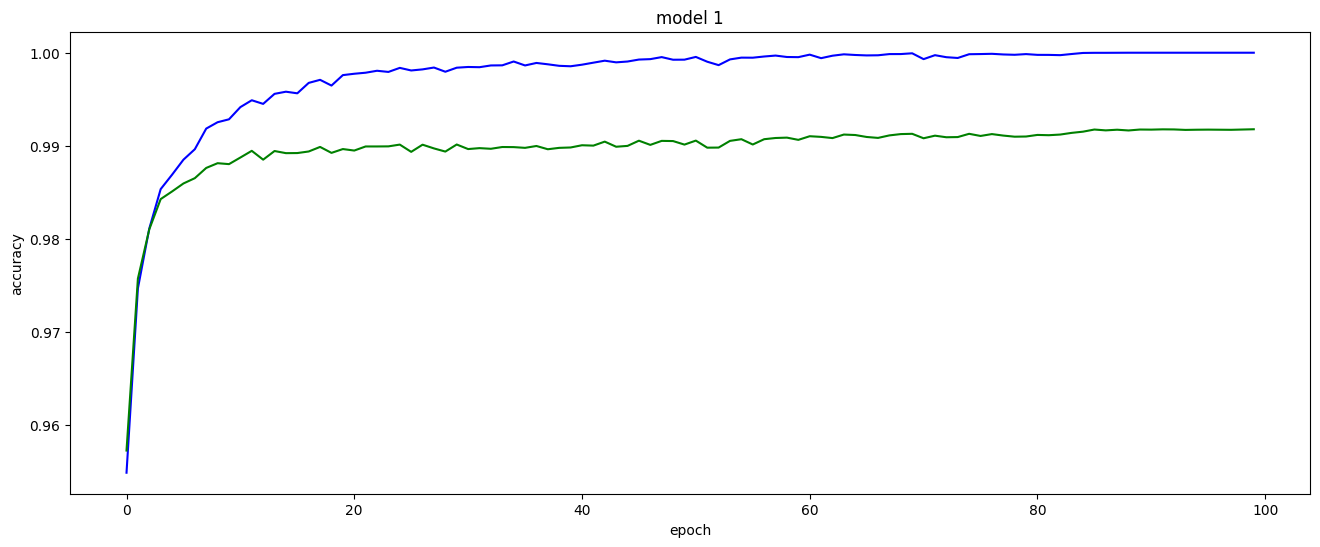

In [8]:
plt.plot(range(100), train_means[0], c = 'blue', label = 'train_accuracy')
plt.plot(range(100), test_means[0], c = 'green', label = 'test_accuracy')
plt.title('model 1')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

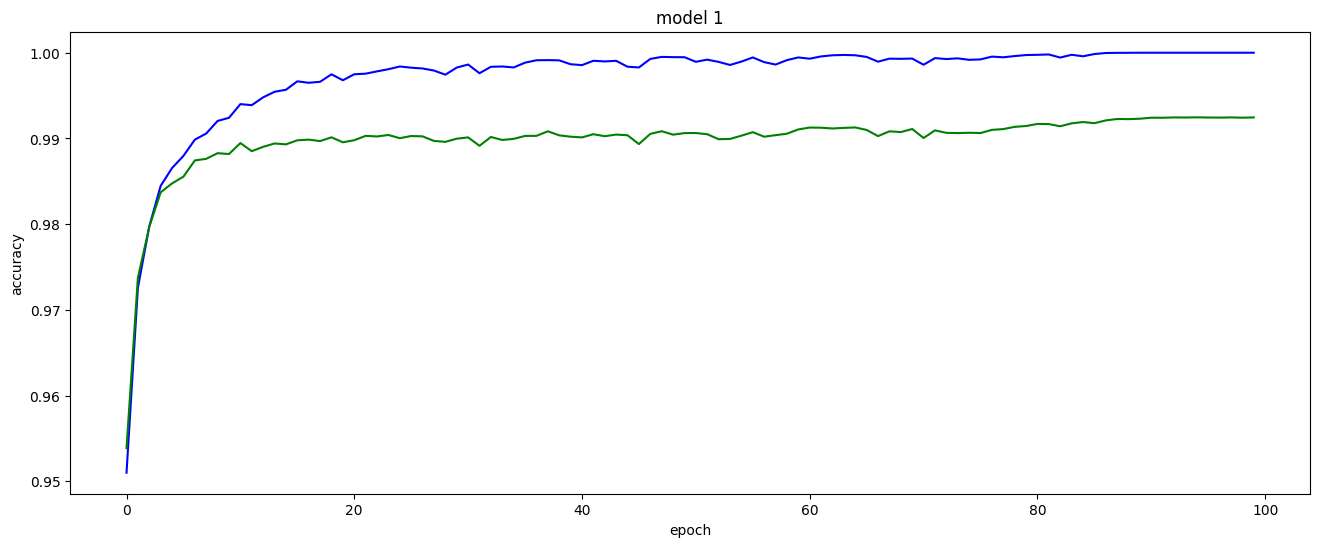

In [9]:
plt.plot(range(100), train_means[1], c = 'blue', label = 'train_accuracy')
plt.plot(range(100), test_means[1], c = 'green', label = 'test_accuracy')
plt.title('model 1')
plt.xlabel('epoch')
plt.ylabel('accuracy')

Text(0.5, 1.0, 'accuracy of two models')

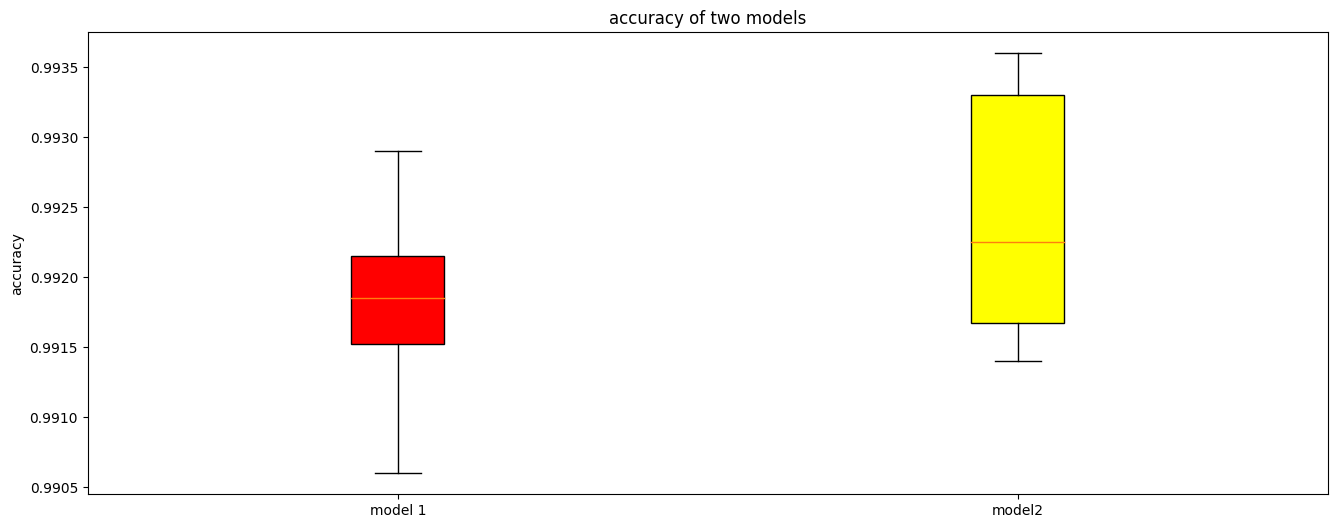

In [12]:
colors = ['red', 'yellow']
for model in range(2):
  y = plt.boxplot(test_accuracy_history[model][-1], positions = [model], patch_artist=True)
  y['boxes'][0].set_facecolor(colors[model])

titles = ['model 1', 'model2']

plt.xticks([0,1], titles)
plt.ylabel('accuracy')
plt.title('accuracy of two models')

Text(0.5, 1.0, 'time of two models')

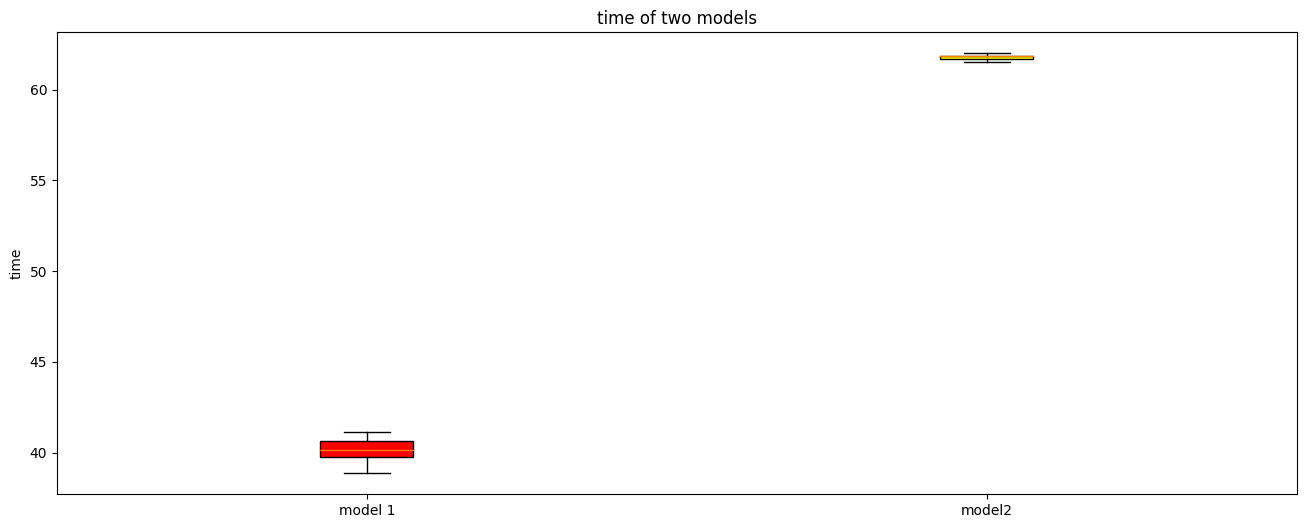

In [16]:
colors = ['red', 'yellow']
for model in range(2):
  y = plt.boxplot(times[model], positions = [model], patch_artist=True)
  y['boxes'][0].set_facecolor(colors[model])

titles = ['model 1', 'model2']

plt.xticks([0,1], titles)
plt.ylabel('time')
plt.title('time of two models')

In [17]:
memories

[[4348.2607421875,
  0.1455078125,
  2164.95556640625,
  2166.50830078125,
  2164.77490234375],
 [1051.39111328125,
  0.81689453125,
  3212.794921875,
  3217.861328125,
  2.0185546875,
  0.1298828125,
  1.6083984375]]

Данные о памяти не валидны для оценки. Но, опираясь на опыт создателей AlexNet, можно предположить, что опертивной памяти используется меньше.

Вывод: Такая конфигурация сети обучается по времени медленнее, но её точность выше. При этом, можно предположить, что оперативной памяти затрачивается меньше.